# Contrastive learning for estimating CMB posteriors
In this notebook, we consider the forward model (cosmology)$\to$(power spectrum), computed using CLASS. We then consider more realistic applications (to compare with CMB likelihoods in montepython), with the CMB power spectrum including cosmic variance, noise contributions, multiple channels, multiple maps, etc.

# ToDo: upgrade NN architecture and train on more simulations w/ GPU. Incorporate reasonable priors and search multiple cosmological parameters.

In [1]:
import pylab as plt
from IPython import display
import numpy as np
import swyft
from classy import Class
import torch
from torch import nn as nn
import scipy

In [3]:
cd /Users/alex/Documents/montepython_public

/Users/alex/Documents/montepython_public


In [3]:
def model(omega_cdm):
    cosmo=Class()
    params = {
    'output': 'tCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.9624, 
    'h': 0.6711,
    'omega_b': 0.022068,
    'omega_cdm': omega_cdm.item()}
    cosmo.set(params)
    cosmo.compute()
    cls = cosmo.lensed_cl(2000)
    #n=[l*(l+1) for l in range(2001)]
    #out=np.sqrt(cls['tt']*n*10**12/(2*np.pi))
    out=cls['tt'][2:]*10**12
    cosmo.struct_cleanup()
    return torch.tensor(out,dtype=torch.float32)

In [4]:
z0=torch.tensor(0.12029)
x0=model(z0)

In [5]:
x0

tensor([1.6118e+02, 7.6059e+01, 4.2932e+01,  ..., 4.9082e-05, 4.9033e-05,
        4.8983e-05])

load noise from file -- in units of $\mu K^2$

In [6]:
noise=np.loadtxt('fake_planck_realistic.dat')
noise=np.array([[elm[0],elm[1]] for elm in noise])

for just $C_\ell^{TT}$, can use simple implementation of cosmic variance. When using other power spectra as well, want to get cross-correlations correct (ToDo).

In [7]:
#this function takes "true" C_l and adds detector noise and cosmic variance
#starting at l=2 until l_max
def addVariance(cl,noise):
    l_max=len(cl)+1
    #Glm=np.random.normal(size=l_max**2+2*l_max-3)
    #n=np.array([2*(l+2)+1 for l in range(len(cl))])
    #GlmSorted={l+2: Glm[(l+2)**2+2*(l+2)-3-2*(l+2)-1:(l+2)**2+2*(l+2)-3] for l in range(l_max-1)}
    clNoise=cl+noise
    cosVar=torch.tensor(np.sqrt([2/(2*l+1) for l in range(2,l_max+1)]))
    clVar=(1+torch.tensor(np.random.normal(size=l_max-1))*cosVar)*clNoise
    return torch.tensor(clVar,dtype=torch.float32)

In [8]:
nn=np.array([l*(l+1) for l in range(2,2001)])

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


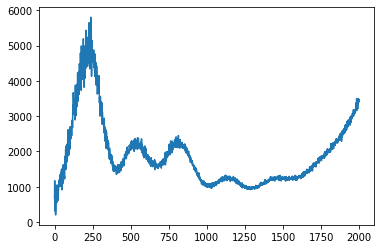

In [9]:
x0Noise=addVariance(x0,noise[:1999,1])
plt.plot(x0Noise*nn);

check against zero detector noise

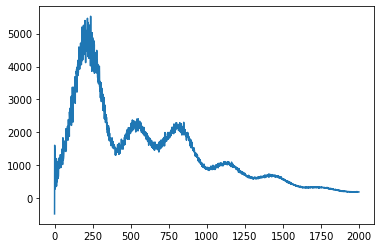

In [17]:
dat=addVariance(x0,0)
plt.plot(dat*nn);
#plt.plot(dat);

This behavior agrees with e.g. Fig. 1 in 1808.05955, which tells us the normalization is okay.

Since running the model sufficiently many times takes a while, preload simulations

In [233]:
zz1=(torch.rand(n_sims)-0.5)*0.1+0.12029
xxzz1=swyft.sample_x(model,zz1)

100%|██████████| 1000/1000 [1:17:18<00:00,  4.64s/it]


In [234]:
#xz1=xz1+xxzz1

In [106]:
#previous cleaning/normalization
#for i in range(1000):
#    xz1[i]=dict(x=xz1[i]['x']*(nn)/(2*np.pi),z=xz1[i]['z'])

In [10]:
#torch.save(xz1,'xz1.pt')
xz1=torch.load('xz1.pt')

In [11]:
class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(1, 10, 5)
        self.conv2 = torch.nn.Conv1d(10, 20, 5)
        self.pool = torch.nn.MaxPool1d(3)
        #conv1.double()
        
    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        print(x)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten()
        return x

add noise to simulations

In [12]:
xzNoise=[]
for i in range(len(xz1)):
    xzNoise.append(dict(x=addVariance(xz1[i]['x'],0),z=xz1[i]['z']))

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [16]:
sw = swyft.SWYFT(model, 1, x0)

manually put some previous simulations into storage

In [17]:
sw.xz_store+=[xzNoise]

In [18]:
np.shape(sw.xz_store[0][0]['x'].unsqueeze(0).unsqueeze(0))

torch.Size([1, 1, 1999])

there is some problem with dimension, need to fix

In [15]:
sw.round(n_sims = 0, n_train = 1000, lr = 1e-3, head = Head())

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/swyft/swyft.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_dim = head(torch.tensor(self.x0).float().to(self.device)).shape[-1]
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/swyft/core.py:292: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_mean = torch.nn.Parameter(torch.tensor(x_mean).float())
/Users/alex/opt/anaconda3/lib/python3.7/site-packages/swyft/core.py:293: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.z_mean = torch.nn.Parameter(torch.tensor(z_mean).

Round:  1
Reusing samples from previous round.
tensor([[[1.6118e+02, 7.6059e+01, 4.2932e+01,  ..., 4.9082e-05,
          4.9033e-05, 4.8983e-05]]])
Network optimization
tensor([[[[ 2.1623e+02,  4.7446e+01,  1.2443e+01,  ...,  7.2104e-11,
            7.3456e-11,  7.3946e-11],
          [ 2.1623e+02,  4.7446e+01,  1.2443e+01,  ...,  7.2104e-11,
            7.3456e-11,  7.3946e-11],
          [-3.3228e+01,  6.8580e+01,  2.0667e+01,  ...,  7.8639e-11,
            7.6067e-11,  7.9508e-11],
          ...,
          [ 2.1732e+02,  9.7384e+01,  3.5608e+01,  ...,  5.0289e-05,
            4.7168e-05,  5.0074e-05],
          [ 3.0511e+02,  2.2055e+01,  4.5358e+01,  ...,  4.7600e-05,
            4.7996e-05,  4.5646e-05],
          [ 3.0511e+02,  2.2055e+01,  4.5358e+01,  ...,  4.7600e-05,
            4.7996e-05,  4.5646e-05]]]])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [10, 1, 5], but got 4-dimensional input of size [1, 1, 128, 1999] instead

old plots

In [133]:
post0 = sw.get_posteriors()

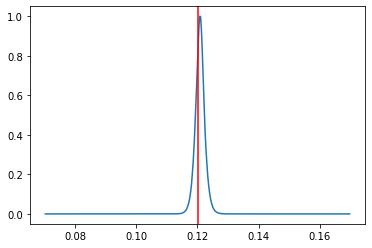

In [134]:
plt.plot(post0[0]['z'],np.exp(post0[0]['lnL']));
plt.axvline(0.12029,c='red');

In [139]:
sw.save('cmbAug4.pt')

/Users/alex/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Head. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


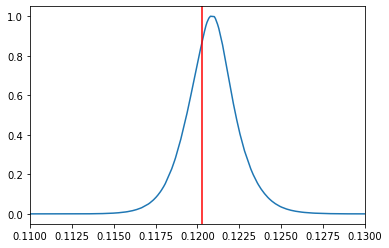

In [138]:
plt.plot(post0[0]['z'],np.exp(post0[0]['lnL']));
plt.axvline(0.12029,c='red');
plt.xlim([0.11,0.13]);

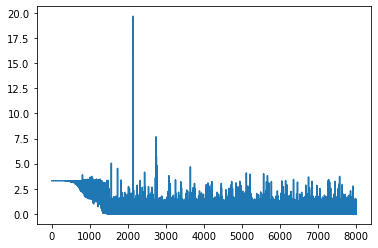

In [135]:
plt.plot(sw.loss_store[0])

In [28]:
params = {
    'output': 'tCl lCl',
    'l_max_scalars': 2000,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.9624, 
    'h': 0.6711,
    'omega_b': 0.022068,
 #   'omega_cdm': 0.12029}
    'omega_cdm': 0.11000}

# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)

# Run the whole code. Depending on your output, it will call the
# CLASS modules more or less fast. For instance, without any
# output asked, CLASS will only compute background quantities,
# thus running almost instantaneously.
# This is equivalent to the beginning of the `main` routine of CLASS,
# with all the struct_init() methods called.
cosmo.compute()

# Access the lensed cl until l=2000
#cls = cosmo.lensed_cl(2000)
cls2 = cosmo.lensed_cl(2000)

# Print on screen to see the output
#print(cls)
# It is a dictionnary that contains the fields: tt, te, ee, bb, pp, tp

# plot something with matplotlib...

# Clean CLASS (the equivalent of the struct_free() in the `main`
# of CLASS. This step is primordial when running in a loop over different
# cosmologies, as you will saturate your memory very fast if you ommit
# it.
cosmo.struct_cleanup()

# If you want to change completely the cosmology, you should also
# clean the arguments, otherwise, if you are simply running on a loop
# of different values for the same parameters, this step is not needed
cosmo.empty()